### 1.Data (loading & preprocessing)

In [1]:
dataset_path = '../datasets/shahnameh-labeled.csv'

In [2]:
import pandas as pd

df = pd.read_csv('../datasets/shahnameh-labeled.csv')
df.sample(5)

,mesra1,mesra2,label
13338,از ایدر ترا داده ام تا به چین,یکی گرد برگرد و بنگر زمین,داستان سیاوش
6634,همان مرغ و ماهی بریشان بزار,بگرید بدریا و بر کوهسار,داستان کاموس کشانی
10070,گر آزار بودیش در دل ز من,سرم برنیفراختی ز انجمن,داستان سیاوش
7860,همه لشکر آن تیر برداشتند,سراسر همه نیزه پنداشتند,داستان کاموس کشانی
2488,بدیدار شاه آمدستش هوا,وزان پس اگر میرد او را روا,داستان دوازده رخ


In [3]:
labels = df.label.unique()
num_lb = labels.shape[0]

id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

In [4]:
from hazm import *

def pre_processing(dataset):
    
    normalizer = Normalizer(token_based=True)
    stopwords = set(stopwords_list())
    
    def clean_poems(poem):
        tokens = [tk for tk in word_tokenize(poem) if tk not in stopwords and len(tk) > 1]
        text = ' '.join(tokens)
        return normalizer.normalize(text)
    
    df['texti'] = df['mesra1'] + ' [SEP] ' + df['mesra2']
    df['texti'] = df['texti'].apply(clean_poems)
    df['label'] = df['label'].apply(lambda x: label2id[x])
    
    return df[['texti', 'label']]

dfc = pre_processing(df)

In [15]:
sample_data = dfc.sample(3_500) #Use only 3,000 data samples for easier training and evaluation.

In [5]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    dfc, test_size=0.2,
    random_state=42, 
    shuffle=True)

### 2.Baseline (Classical Approach)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#Using LogisticRegression
pipe = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', max_features=40_000, ngram_range=(1, 3))),
                 ('lr', LogisticRegression(multi_class="ovr", solver="liblinear"))])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

classifier = GridSearchCV(pipe, parameters, cv=5, verbose=1).fit(train_df['texti'], train_df['label'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [7]:
predicted = classifier.predict(test_df['texti'])

In [8]:
from sklearn.metrics import accuracy_score, f1_score

baseline_accuracy = accuracy_score(test_df.label, predicted)

print(F"accuracy_score: {baseline_accuracy},",
      F"f1_score: {f1_score(test_df.label, predicted, average='macro')}")

accuracy_score: 0.46575846833578793, f1_score: 0.372979002555389


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0 --> داستان دوازده رخ
1 --> داستان هفتخوان اسفندیار
2 --> داستان اکوان دیو
3 --> داستان بیژن و منیژه
4 --> داستان رستم و اسفندیار
5 --> داستان کاموس کشانی
6 --> داستان خاقان چین
7 --> داستان رستم و شغاد
8 --> داستان سیاوش
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


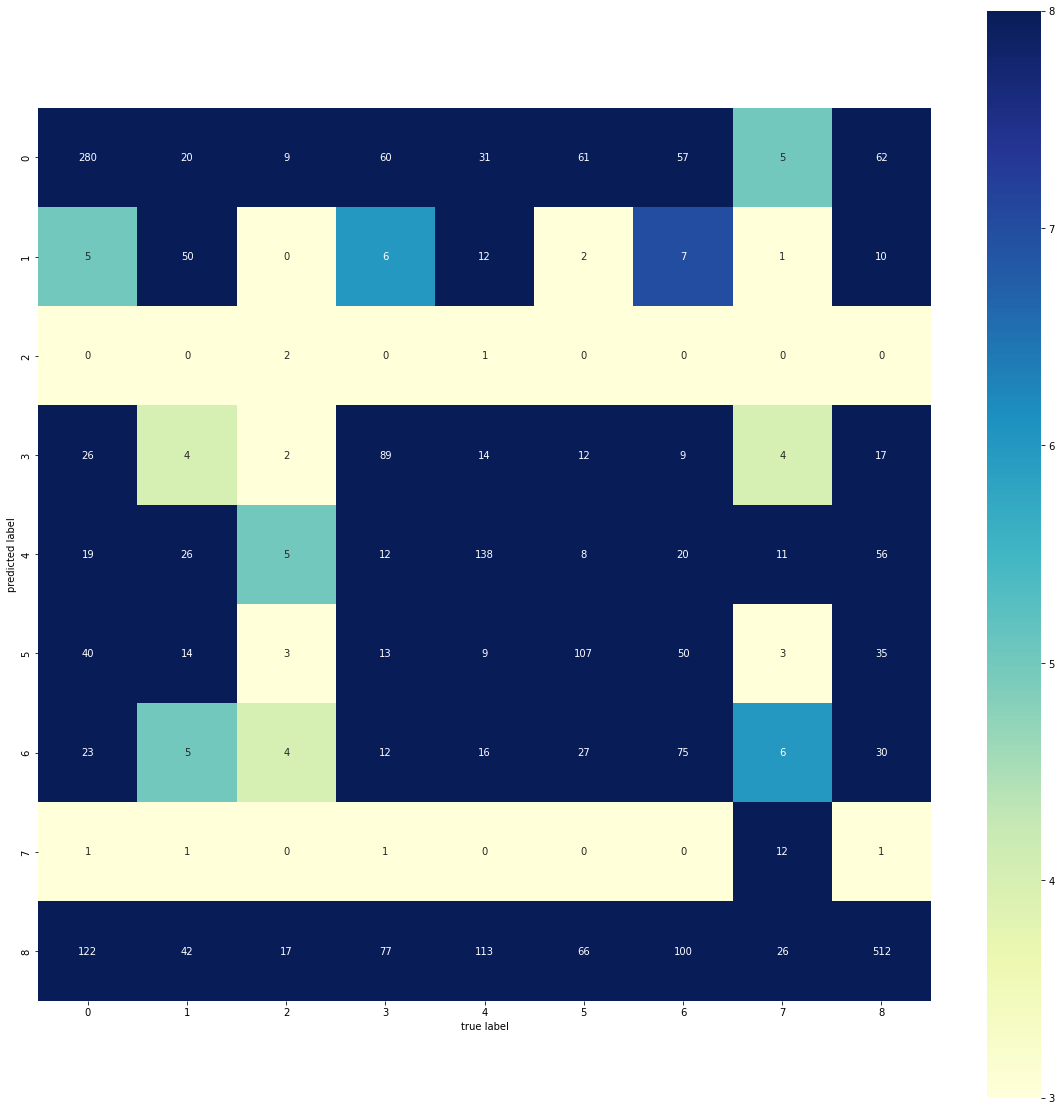

In [9]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(test_df['label'], predicted)

plt.figure(figsize=(20,20))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu", vmin=3, vmax=8)

print(
    '+' * 100 + '\n' +
    '\n'.join([F'{i} --> {name}' for i, name in enumerate(labels)]) +
    '\n' + '+' * 100
)

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### 3.Bert (Using Transformer)

In [10]:
import torch
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)

logger = logging.getLogger(__name__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
BERT_MODEL = "HooshvareLab/bert-fa-zwnj-base"

In [12]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2id)).to(device)

2022-06-16 16:40:01.899795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alireza/.mujoco/mujoco210/bin
2022-06-16 16:40:01.899817: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.

In [13]:
import numpy as np

MAX_SEQ_LENGTH=100

class BertInputItem:

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.label_id = label_id
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        
        
def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer):
    
    input_items = []
    examples = zip(example_texts, example_labels)
    
    for (ex_index, (text, label)) in enumerate(examples):

        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        segment_ids = [0] * len(input_ids)
        input_mask = [1] * len(input_ids)

        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        input_items.append(
            BertInputItem(text=text,
                          label_id=label,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids))

    return input_items

In [16]:
train_df, rest = train_test_split(
    dfc, test_size=0.3, random_state=42, shuffle=True)

test_df, val_df = train_test_split(
    rest, test_size=0.5, random_state=42, shuffle=True)

In [17]:
train_features = convert_examples_to_inputs(
    train_df['texti'], train_df['label'], label2id, MAX_SEQ_LENGTH, tokenizer)

val_features = convert_examples_to_inputs(
    val_df['texti'], val_df['label'], label2id, MAX_SEQ_LENGTH, tokenizer)

test_features = convert_examples_to_inputs(
    test_df['texti'], test_df['label'], label2id, MAX_SEQ_LENGTH, tokenizer)

In [18]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    
    return dataloader

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(val_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

In [19]:
def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            output = model(input_ids, attention_mask=input_mask,
                            token_type_ids=segment_ids, labels=label_ids)
            
            tmp_eval_loss, logits = output['loss'], output['logits']
        
        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

In [20]:
from torch.optim.lr_scheduler import LinearLR
from torch.optim import AdamW

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 1 #changed!

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
start_factor = 0.5
learning_rate = 5e-5

optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = LinearLR(optimizer, start_factor=start_factor, total_iters=num_train_steps)

In [ ]:
import torch
import os

from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import classification_report, precision_recall_fscore_support

from tqdm.notebook import tqdm
from tqdm import trange

PATIENCE = 5
MAX_GRAD_NORM = 5
OUTPUT_DIR = "./results"
MODEL_FILE_NAME = "shahnameh_model.bin"

loss_history = []
no_improvement = 0
for _ in trange(NUM_TRAIN_EPOCHS, desc="Epoch"):
    model.train()
    
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(
            input_ids, attention_mask=input_mask, 
            token_type_ids=segment_ids, labels=label_ids)
        
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
    val_loss, _, _ = evaluate(model, dev_dataloader)
    
    print("Loss history:", loss_history)
    print("Val loss:", val_loss)
    
    if len(loss_history) == 0 or val_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1
    
    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        break
    
    loss_history.append(val_loss)

Epoch:   0%|                                              | 0/1 [00:00<?, ?it/s]

Training iteration:   0%|          | 0/594 [00:00<?, ?it/s]

In [ ]:
model_state_dict = torch.load(
    os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)

model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL, state_dict=model_state_dict, num_labels = len(labels)).to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, dev_correct, dev_predicted = evaluate(model, dev_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Training performance:", 
      precision_recall_fscore_support(train_correct, train_predicted, average="macro"))
print("Test performance:", 
      precision_recall_fscore_support(test_correct, test_predicted, average="macro"))
print("Development performance:", 
      precision_recall_fscore_support(dev_correct, dev_predicted, average="macro"))

bert_accuracy = np.mean(test_predicted == test_correct)

print(classification_report(test_correct, test_predicted, target_names=labels))

In [ ]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"accuracy": {"baseline": baseline_accuracy, "BERT": bert_accuracy}})
plt.rcParams['figure.figsize'] = (7,4)
df.plot(kind="bar")

### 4.Huggingface (Text Classification)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

train_df, test_df = train_test_split(
    dfc.copy(), test_size=0.2,
    random_state=42, 
    shuffle=True)

train_dataset, test_dataset = Dataset.from_dict(train_df), Dataset.from_dict(test_df)

dataset = DatasetDict({"train":train_dataset,"test":test_dataset})

In [ ]:
BERT_MODEL = "HooshvareLab/bert-fa-zwnj-base"

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

def preprocess_function(examples):
    return tokenizer(examples["texti"], truncation=True)

tokenized_imdb = dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=len(label2id))

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10, #changed!
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
text = "رستم به دیدن اسفندیار رفت ولی نبود و مجبور شد بدون بزم برگردد زرشک"

In [ ]:
def which_classes_are(texts):

    labels = [int(x['label'].split('_')[1]) for x in classifier(texts)]
    return labels, [id2label[x] for x in labels]

which_classes_are([text])

In [ ]:
predictions = which_classes_are(dataset['test']['texti'])

In [ ]:
from datasets import load_metric

metric = load_metric("f1")

print("f1_score: ", metric.compute(
    predictions=predictions[0], references=dataset['test']['label'], average='macro'))

metric = load_metric("accuracy")

print("accuracy: ", metric.compute(
    predictions=predictions[0], references=dataset['test']['label']))

In [ ]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(dataset['test']['label'], predictions[0])

plt.figure(figsize=(20,20))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu", vmin=3, vmax=8)

print(
    '+' * 100 + '\n' +
    '\n'.join([F'{i} --> {name}' for i, name in enumerate(labels)]) +
    '\n' + '+' * 100
)

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()